In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

In [11]:
raw = pd.read_csv("./all.csv")
raw.info()
data = raw.drop(raw.columns.values[0], axis=1)
data = data.fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37617 entries, 0 to 37616
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Index            37617 non-null  int64  
 1   Price            36924 non-null  float64
 2   Description      37148 non-null  object 
 3   Kind             37617 non-null  object 
 4   Location         37617 non-null  object 
 5   Size             37591 non-null  float64
 6   Parking_slot     13480 non-null  float64
 7   Air_condition    16624 non-null  float64
 8   Heater_shower    13175 non-null  float64
 9   Furnish          12529 non-null  float64
 10  Inner_toilet     9299 non-null   float64
 11  Size_total_bool  5539 non-null   float64
 12  Source           37617 non-null  object 
 13  ward             37617 non-null  object 
 14  district         37617 non-null  object 
 15  province         37617 non-null  object 
 16  lat              37617 non-null  float64
 17  lng         

In [12]:
data.loc[data["Kind"] == "CCMN", "Parking_slot"] = 1
data.loc[data["Kind"] == "CCMN", "Air_condition"] = 1
data.loc[data["Kind"] == "CCMN", "Heater_shower"] = 1
data.loc[data["Kind"] == "CCMN", "Inner_toilet"] = 1

data.loc[data["Kind"] == "Homestay", "Parking_slot"] = 1
data.loc[data["Kind"] == "Homestay", "Air_condition"] = 1
data.loc[data["Kind"] == "Homestay", "Heater_shower"] = 1

In [13]:
data['Price'].describe()

count     37617.000000
mean        115.213744
std        5906.864232
min           0.000000
25%           2.500000
50%          10.000000
75%          33.000000
max      900000.000000
Name: Price, dtype: float64

In [14]:
data_categorical = data[['Kind', 'Source']]
data_float = data.select_dtypes(['float64'])
data_categorical_one_hot = pd.get_dummies(data_categorical)
data_processed = pd.concat([data_float, data_categorical_one_hot], axis=1)

data_processed = data_processed[(data_processed['Price'] > 1) & (data_processed['Price'] <= 15)]
data_processed = data_processed[(data_processed['Size'] > 0) & (data_processed['Size'] <= 35)]
data_processed['Price_per_m2'] = data_processed['Price'] / data_processed['Size']
data_processed = data_processed[data_processed['Price_per_m2'] <= 0.3]
data_processed = data_processed.drop('Price_per_m2', axis=1)

data_processed = data_processed[data_processed['Source_alonhadat'] == 0]
data_processed = data_processed.drop('Source_alonhadat', axis=1)
data_processed1 = data_processed.drop(['lat', 'lng'], axis=1)
data_processed1

,Price,Size,Parking_slot,Air_condition,Heater_shower,Furnish,Inner_toilet,Size_total_bool,dist,num_hospital,num_building,num_school,Kind_CCMN,Kind_Chung cư,Kind_Homestay,Kind_Phòng trọ,Source_chotot,Source_phongtro123,Source_thuephongtro
25720,4.5,35.0,1.0,1.0,1.0,1.0,1.0,0.0,5.995406,0.0,0.0,1.0,1,0,0,0,0,1,0
25721,1.8,22.0,1.0,0.0,1.0,0.0,0.0,0.0,2.975723,0.0,10.0,1.0,0,0,0,1,0,1,0
25722,2.5,18.0,1.0,0.0,1.0,1.0,0.0,0.0,5.036005,0.0,1.0,0.0,0,0,0,1,0,1,0
25723,2.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,4.385111,0.0,0.0,0.0,0,0,0,1,0,1,0
25724,2.2,15.0,1.0,1.0,1.0,0.0,1.0,0.0,4.385111,0.0,0.0,0.0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37610,2.3,18.0,0.0,0.0,0.0,0.0,0.0,0.0,5.199598,0.0,2.0,1.0,0,0,0,1,1,0,0
37612,3.3,25.0,1.0,0.0,1.0,1.0,1.0,0.0,6.117014,0.0,2.0,8.0,0,0,0,1,1,0,0
37613,2.5,20.0,1.0,0.0,0.0,0.0,1.0,0.0,6.110135,0.0,0.0,0.0,0,0,0,1,1,0,0
37614,3.0,34.0,0.0,0.0,1.0,0.0,0.0,0.0,7.491218,0.0,14.0,3.0,0,0,0,1,1,0,0


In [15]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb

target= np.array(data_processed['Price'])
args = np.argwhere((target > 1) & (target < 15)).ravel()
features = data_processed1.drop(['Price'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

target = target[args]
features = features[args]
print(target.shape, features.shape, args.shape)
print(target.mean())
kf = KFold(n_splits=5, random_state=42, shuffle=True)

(9321,) (9321, 18) (9321,)
2.2913320322926727


In [16]:
accuracies = []
maes = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]
    

    rf = RandomForestRegressor(n_estimators = 1000, random_state=42,
                                criterion='mse', bootstrap=True, n_jobs=12)
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))

    mae = round(np.mean(errors), 2)
    print('Mean Absolute Error:', mae)
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)
    maes.append(mae)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
print('Average MAE:', np.mean(maes))

Mean Absolute Error: 0.2
Accuracy: 89.14 %.
Mean Absolute Error: 0.2
Accuracy: 88.43 %.
Mean Absolute Error: 0.2
Accuracy: 88.66 %.
Mean Absolute Error: 0.2
Accuracy: 88.46 %.
Mean Absolute Error: 0.18
Accuracy: 89.84 %.
Average accuracy: 88.90633391201631
Average MAE: 0.196


In [17]:
accuracies = []
maes = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]
    

    xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1, n_estimators=1000, random_state=42)
    xgb_r.fit(data_train, target_train)

    predictions = xgb_r.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))

    mae = round(np.mean(errors), 2)
    print('Mean Absolute Error:', mae)
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)
    maes.append(mae)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
print('Average MAE:', np.mean(maes))

Mean Absolute Error: 0.21
Accuracy: 88.62 %.
Mean Absolute Error: 0.21
Accuracy: 88.39 %.
Mean Absolute Error: 0.22
Accuracy: 87.89 %.
Mean Absolute Error: 0.22
Accuracy: 88.19 %.
Mean Absolute Error: 0.2
Accuracy: 89.56 %.
Average accuracy: 88.52889704933673
Average MAE: 0.21200000000000002


In [18]:
accuracies = []
maes = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]
    

    ridge = Ridge()
    ridge.fit(data_train, target_train)

    predictions = ridge.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))

    mae = round(np.mean(errors), 2)
    print('Mean Absolute Error:', mae)
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)
    maes.append(mae)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
print('Average MAE:', np.mean(maes))

Mean Absolute Error: 0.21
Accuracy: 87.7 %.
Mean Absolute Error: 0.22
Accuracy: 86.57 %.
Mean Absolute Error: 0.22
Accuracy: 86.93 %.
Mean Absolute Error: 0.22
Accuracy: 87.32 %.
Mean Absolute Error: 0.2
Accuracy: 88.44 %.
Average accuracy: 87.3898953893299
Average MAE: 0.21400000000000002


In [19]:
accuracies = []
maes = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]
    

    lasso = Lasso()
    lasso.fit(data_train, target_train)

    predictions = lasso.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))

    mae = round(np.mean(errors), 2)
    print('Mean Absolute Error:', mae)
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)
    maes.append(mae)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
print('Average MAE:', np.mean(maes))

Mean Absolute Error: 0.23
Accuracy: 85.42 %.
Mean Absolute Error: 0.25
Accuracy: 84.2 %.
Mean Absolute Error: 0.24
Accuracy: 84.44 %.
Mean Absolute Error: 0.23
Accuracy: 85.29 %.
Mean Absolute Error: 0.23
Accuracy: 85.63 %.
Average accuracy: 84.996360613608
Average MAE: 0.236


In [20]:
estimators = [
    ('lasso', Lasso()),
    ('ridge', Ridge()),
    ('xgboost', xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1, n_estimators=1000, random_state=42)),
    ('randomforest', RandomForestRegressor(n_estimators = 1000, n_jobs=-1, random_state=42, criterion='mse', bootstrap=True))
]

accuracies = []
maes = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]


    stack = StackingRegressor(estimators=estimators)
    stack.fit(data_train, target_train)

    predictions = stack.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))

    mae = round(np.mean(errors), 2)
    print('Mean Absolute Error:', mae)
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)
    maes.append(mae)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
print('Average MAE:', np.mean(maes))

Mean Absolute Error: 0.2
Accuracy: 88.64 %.
Mean Absolute Error: 0.21
Accuracy: 87.75 %.
Mean Absolute Error: 0.2
Accuracy: 88.1 %.
Mean Absolute Error: 0.2
Accuracy: 88.29 %.
Mean Absolute Error: 0.19
Accuracy: 89.17 %.
Average accuracy: 88.39172741414976
Average MAE: 0.2


['Size' 'Parking_slot' 'Air_condition' 'Heater_shower' 'Furnish'
 'Inner_toilet' 'Size_total_bool' 'dist' 'num_hospital' 'num_building'
 'num_school' 'Kind_CCMN' 'Kind_Chung cư' 'Kind_Homestay' 'Kind_Phòng trọ'
 'Source_chotot' 'Source_phongtro123' 'Source_thuephongtro']


Text(0.5, 0, 'Mức độ')

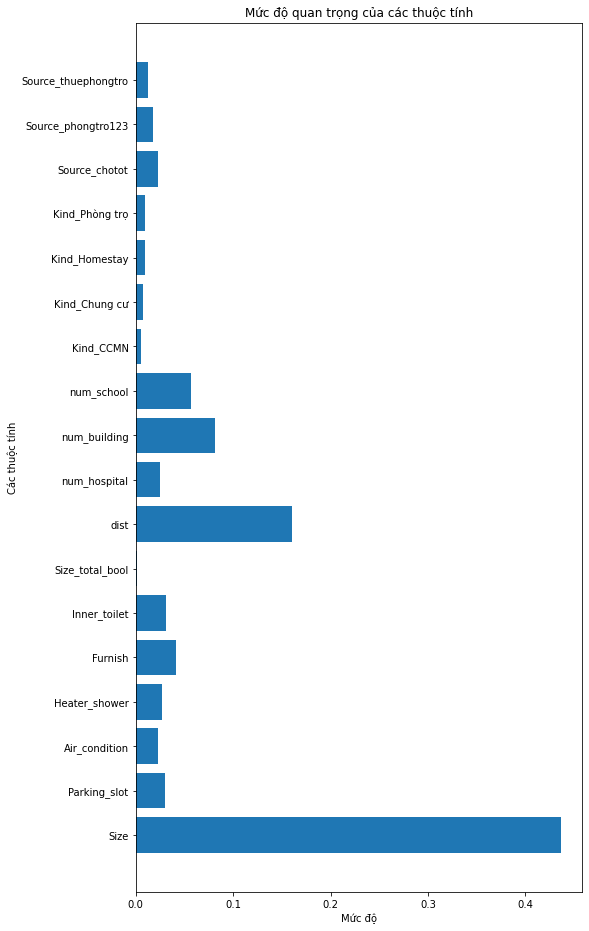

In [21]:
import matplotlib.pyplot as plt

features_name = data_processed.drop(['lat', 'lng', 'Price'], axis = 1).columns.values
n = len(features_name)
print(features_name)
plt.figure(figsize=(8,16))
plt.barh(range(n), rf.feature_importances_)
plt.yticks(range(n), features_name)
plt.title("Mức độ quan trọng của các thuộc tính")
plt.ylabel("Các thuộc tính")
plt.xlabel("Mức độ")

In [36]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [37]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features, target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 45.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [39]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [40]:
accuracies = []
maes = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]
    

    rf = RandomForestRegressor(n_estimators = 400, random_state=42,
                                min_samples_split=2,
                                min_samples_leaf=4,
                                max_features='sqrt',
                                max_depth=70,
                                criterion='mse',
                                bootstrap=True)
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))

    mae = round(np.mean(errors), 2)
    print('Mean Absolute Error:', mae)
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)
    maes.append(mae)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)
print('Average MAE:', np.mean(maes))

Mean Absolute Error: 0.19
Accuracy: 88.94 %.
Mean Absolute Error: 0.2
Accuracy: 87.64 %.
Mean Absolute Error: 0.2
Accuracy: 87.87 %.
Mean Absolute Error: 0.2
Accuracy: 88.3 %.
Mean Absolute Error: 0.17
Accuracy: 89.66 %.
Average accuracy: 88.48343249669027
Average MAE: 0.192
